# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
import numpy as np
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

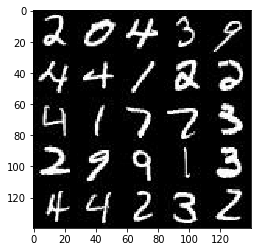

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

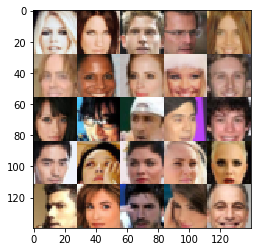

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Placeholders
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/upgrade/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/upgrade/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Disciminator model
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        relu1 = tf.maximum(0.1 * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.1 * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        dropout = tf.nn.dropout(flat,0.3)
        logits = tf.layers.dense(dropout, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Generator model
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)
        
        upsample = tf.image.resize_nearest_neighbor(x1, (7,7))
        x2 = tf.layers.conv2d_transpose(upsample, 64, 5, 
                                        strides=1, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, 
                                        strides=2, 
                                        padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.1 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 
                                            strides=2, 
                                            padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
                    
    print("Finish training")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6684... Generator Loss: 3.8679
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 2.4621... Generator Loss: 0.1291
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 1.8160
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 2.2038


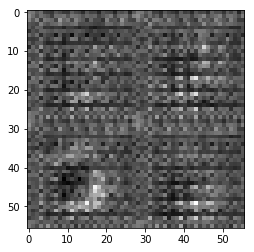

Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.3291
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 1.9769
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 1.4607
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.6518


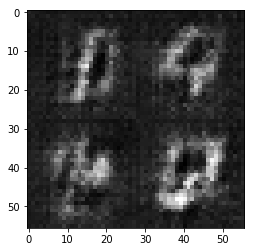

Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.3200
Epoch 1/2... Discriminator Loss: 1.1472... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 1.3025


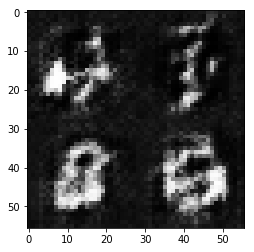

Epoch 1/2... Discriminator Loss: 1.1184... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 1.3722
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 1.3532
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.5845
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.6004


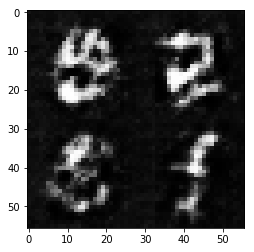

Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.2911
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 0.6966
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 1.0734
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.3153
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.9701
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.4933


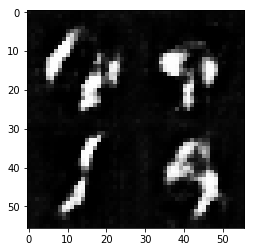

Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.4474
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 1.5573
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.6105... Generator Loss: 0.2685
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 1.1416
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.9251


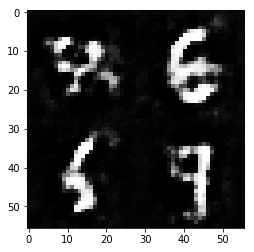

Epoch 1/2... Discriminator Loss: 1.5441... Generator Loss: 0.2886
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.8740
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.6156
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 1.2738
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.5200
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.5458


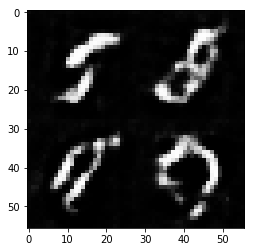

Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 1.0990
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 2.0705... Generator Loss: 1.7747
Epoch 1/2... Discriminator Loss: 1.2095... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 1.1956... Generator Loss: 0.9356


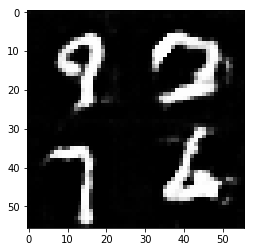

Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 1.0112
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.6070


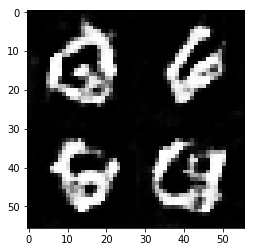

Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.5265... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.2465... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.3616


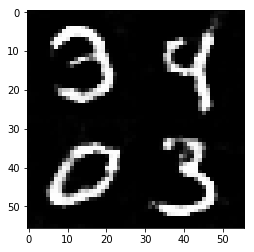

Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.5041
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 1.1182
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 0.6481
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.1999... Generator Loss: 0.8770
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.5128


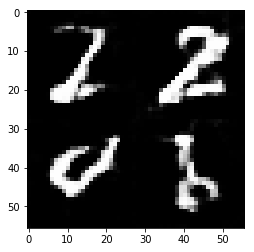

Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.7017
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.4722
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.4008
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.9306
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 1.5657... Generator Loss: 1.6654
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.7483


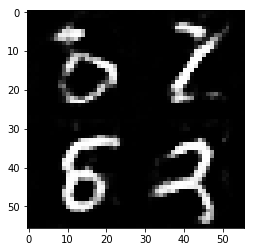

Epoch 2/2... Discriminator Loss: 1.1297... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 1.1562... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.2156
Epoch 2/2... Discriminator Loss: 1.2563... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 1.2094... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.5008
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7474


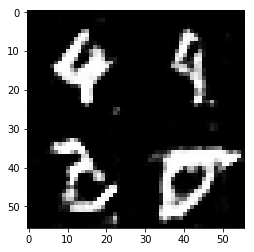

Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.5459
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.6545
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.4807
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.8816


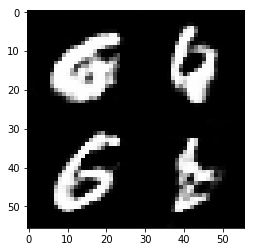

Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 1.2523
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.5177
Epoch 2/2... Discriminator Loss: 2.4100... Generator Loss: 0.0911
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.5248
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7924


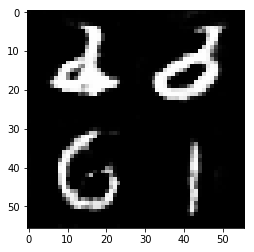

Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.6921
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.3724
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.5620


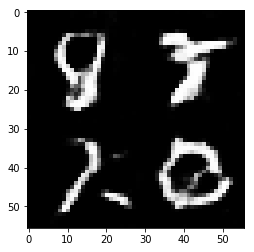

Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.4940


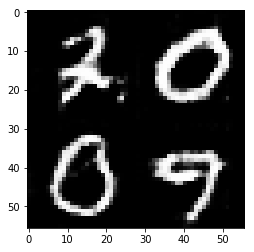

Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.4611
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.6592
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.5109
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 1.4753
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.4133


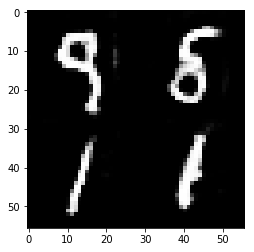

Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.7749
Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 0.2764
Epoch 2/2... Discriminator Loss: 1.2077... Generator Loss: 0.4671
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.4079
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 0.3518
Finish training


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6815... Generator Loss: 9.1026
Epoch 1/1... Discriminator Loss: 1.9538... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 2.0392
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 2.9995
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.7532
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.9228... Generator Loss: 4.6552
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.6325
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.2061


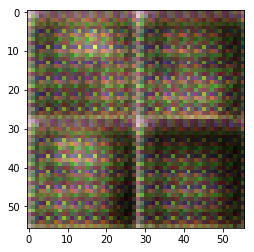

Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 4.2413
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 3.0790
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 2.1817
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 2.4191
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 2.4242
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 2.3160


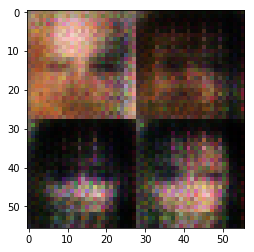

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.6083
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 2.2256
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 2.0808
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 2.1056
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 1.2738


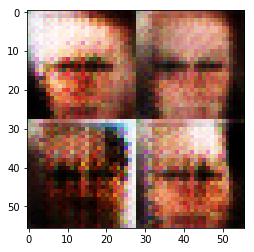

Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.5395
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.8937


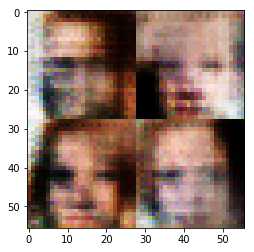

Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.6931
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 2.1677
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 1.9215
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.9106


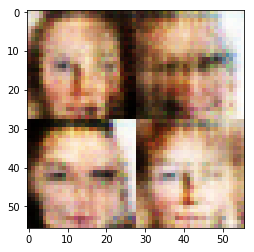

Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.5348
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.1455


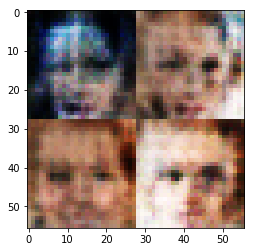

Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.5868
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.2302
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.4472


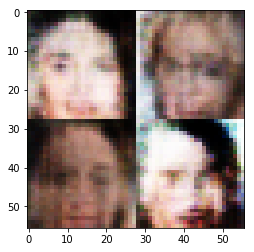

Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.7744
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.9747... Generator Loss: 0.1946
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7253


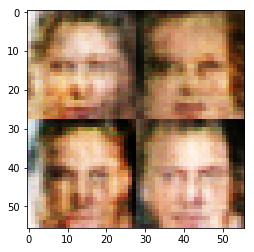

Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.5334
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.3148
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.4775


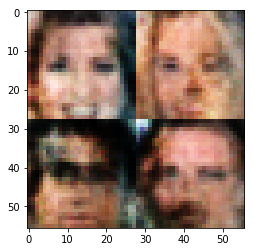

Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.4751
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.4418
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.1425


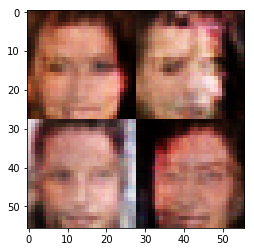

Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9801


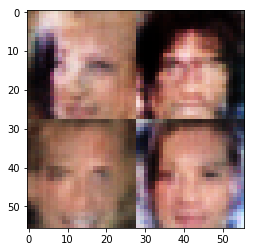

Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.6708
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.6183
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.0523


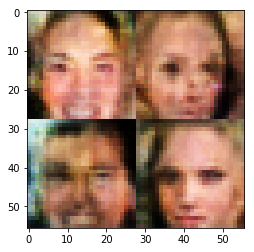

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.9894


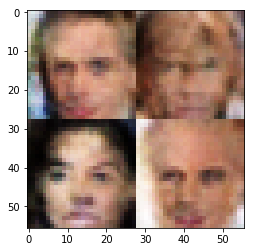

Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.1855


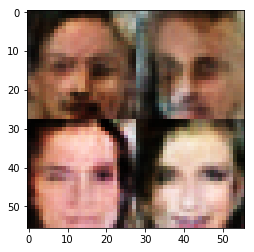

Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 1.6994
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.5604


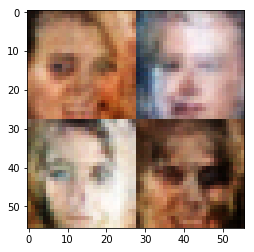

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7332


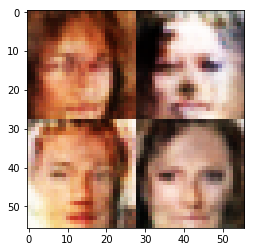

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9625
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.5865
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.1421


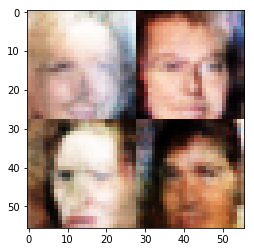

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.0256


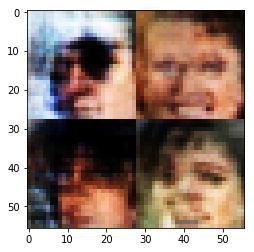

Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.3181


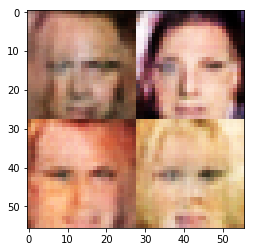

Epoch 1/1... Discriminator Loss: 1.7135... Generator Loss: 0.3357
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.0954... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.2552
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8271


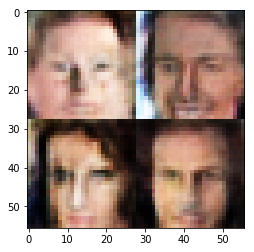

Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.3570


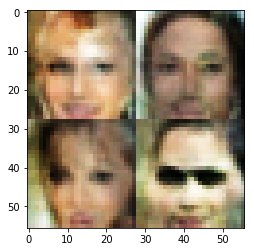

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.4506
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7493


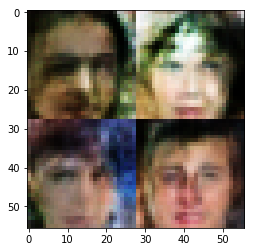

Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 1.4471


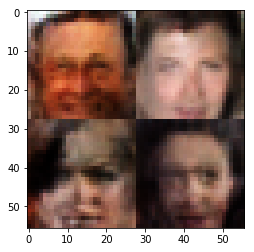

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.9287


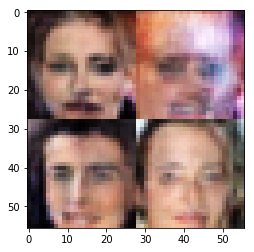

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.4646
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.0020


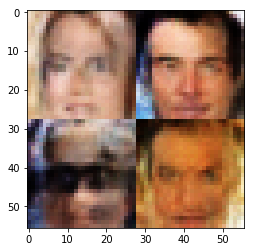

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.4753
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.0330


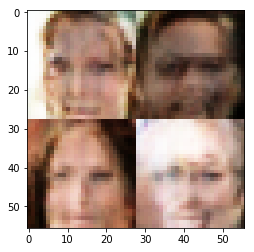

Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.8605... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8475


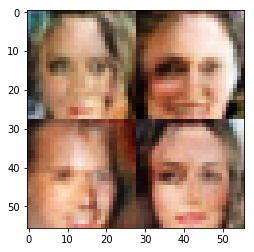

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.0359


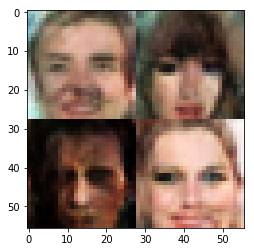

Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 1.3595
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.7831


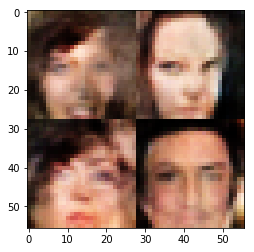

Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.2276


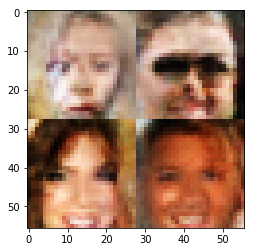

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9416


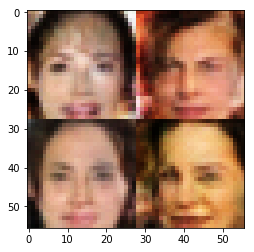

Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7663
Finish training


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.